# W-GAN Restore
This notebook shows how to restore the generative model from the checkpoints

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import glob
import utils
import traceback
import numpy as np
import tensorflow as tf
import models_64x64 as models
import matplotlib
import matplotlib.pyplot as plt
import os

C:\Users\Kang\Anaconda3\envs\cs231n\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Biuld up the Graph

In [2]:
"""Set the necessary parameters"""
lr = 0.0002
z_dim = 100
gpu_id = 3


"""Biuld up the graph again exactly the same as the train_cartoon_wgan_gp.py file"""
with tf.device('/gpu:%d' % gpu_id):
    ''' models '''
    generator = models.generator
    discriminator = models.discriminator_wgan_gp

    ''' graph '''
    # inputs
    real = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])

    # generate
    fake = generator(z, reuse=False)

    # dicriminate
    r_logit = discriminator(real, reuse=False)
    f_logit = discriminator(fake)

    # losses
    def gradient_penalty(real, fake, f):
        def interpolate(a, b):
            shape = tf.concat((tf.shape(a)[0:1], tf.tile([1], [a.shape.ndims - 1])), axis=0)
            alpha = tf.random_uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.get_shape().as_list())
            return inter

        x = interpolate(real, fake)
        pred = f(x)
        gradients = tf.gradients(pred, x)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=list(range(1, x.shape.ndims))))
        gp = tf.reduce_mean((slopes - 1.)**2)
        return gp

    wd = tf.reduce_mean(r_logit) - tf.reduce_mean(f_logit)
    gp = gradient_penalty(real, fake, discriminator)
    d_loss = -wd + gp * 10.0
    g_loss = -tf.reduce_mean(f_logit)

    # otpims
    d_var = utils.trainable_variables('discriminator')
    g_var = utils.trainable_variables('generator')
    d_step = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5).minimize(d_loss, var_list=d_var)
    g_step = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5).minimize(g_loss, var_list=g_var)

    # summaries
    d_summary = utils.summary({wd: 'wd', gp: 'gp'})
    g_summary = utils.summary({g_loss: 'g_loss'})

    # sample
    f_sample = generator(z, training=False)

## Load the Checkpoints

In [3]:
#Get the session of graph above
sess = utils.session()
it_cnt, update_cnt = utils.counter()
saver=tf.train.Saver(max_to_keep=5)
summary_writer = tf.summary.FileWriter('./summaries/wgan_gp_new_img', sess.graph)

# set the checkpoint directory
ckpt_dir = './checkpoints/wgan_gp_new_img/'

utils.load_checkpoint(ckpt_dir, sess)

 [*] Loading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoints/wgan_gp_new_img/Epoch_(1999)_(1of1).ckpt
 [*] Loading successful! Copy variables from ./checkpoints/wgan_gp_new_img/Epoch_(1999)_(1of1).ckpt


True

## Generate Samples with the Gnerator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


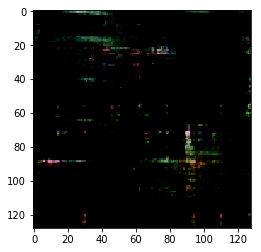

In [4]:
z_dim = 100 # the dimension of random noise
n_size = 4 # the number of pictures you want to generate
z_ipt_sample = np.random.normal(size=[n_size, z_dim]) # n_size * 64 * 64                                 
f_sample_opt = sess.run(f_sample, feed_dict={z: z_ipt_sample})
img = utils.immerge(f_sample_opt, 2, 2) # 10*10 display ==== n_size
plt.imshow(img)

## Export the Generated Pictures

In [5]:
# export all the image generated 64*64*3
save_path = '../data/wheel/g_result'
if not os.path.exists(save_path):
    os.makedirs(save_path)
for i in range(n_size):
    array = f_sample_opt[i]
    matplotlib.image.imsave(save_path + '/%s.png'%i, array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
